# Tutorial 5: Rotated PCA
Example on SST data (from the last tutorial).  Gridded monthly sea surface temperature data for tropical Pacific from ERA Interim reanalysis.  Period: Jan 1979 - Jun 2017

In [26]:
#import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.signal import find_peaks

First, we'll do regular PCA to the compare to rotated PCA

In [12]:
#load the SST anomalies (the processed data from alst time -- no need to process again!)
T2d_anomalies_smooth = pd.read_csv('SST_anomalies_data.csv')


In [20]:
#do PCA (as in previous tutorial)

data = T2d_anomalies_smooth

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

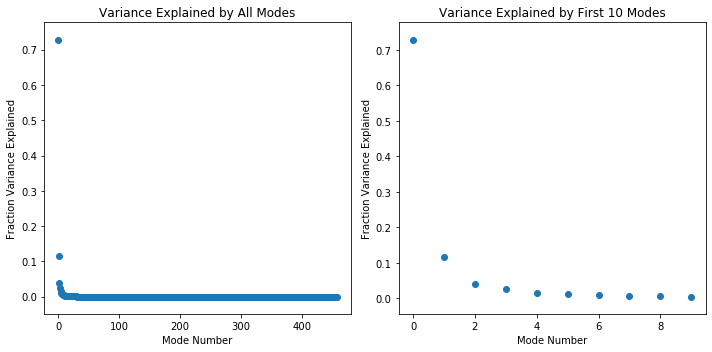

In [21]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

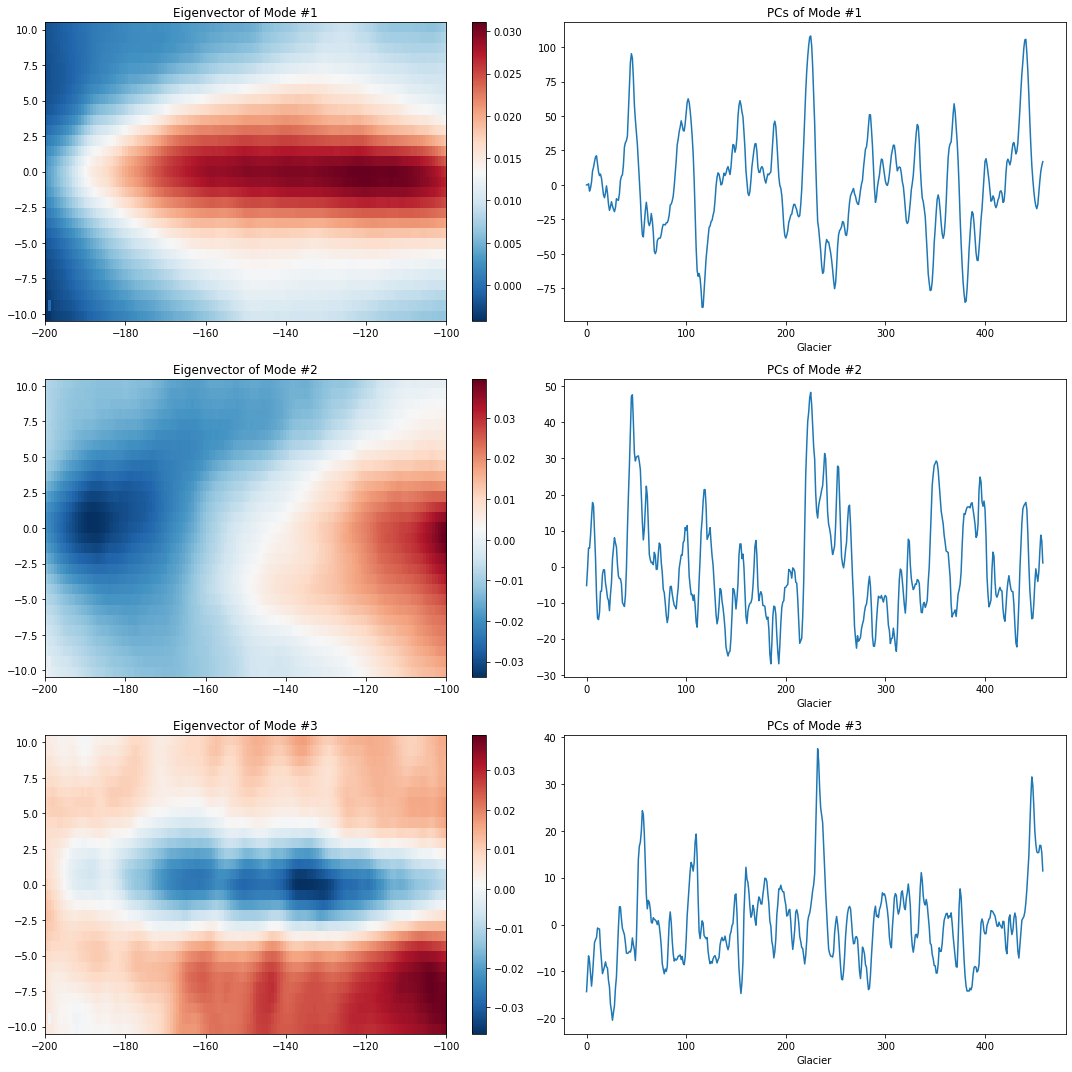

In [24]:
#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure!

n = 3

extent = [-200,-100,-10.5,10.5]
plt.figure(figsize=(15,5*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.imshow(np.reshape(eigvecs[kk,:],(29,135)),extent=extent,cmap = 'RdBu_r',aspect='auto')
    plt.xlim(extent[:2])
    plt.ylim(extent[2:])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Time')
    
    plt.tight_layout()

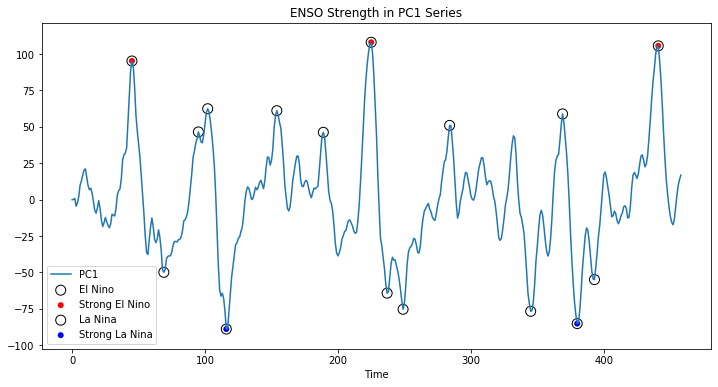

In [27]:
#find El Nino and La Nina as peaks/valleys in PC1 time series

allElNino = find_peaks(PCs[:,0],height=45, width=2)[0]
allLaNina= find_peaks(-PCs[:,0], height=45, width=2)[0]

strongElNino = find_peaks(PCs[:,0], height=80, width=2)[0]
strongLaNina = find_peaks(-PCs[:,0], height=85, width=2)[0]

#visualize
plt.figure(figsize=(12,6))

plt.plot(PCs[:,0])
plt.scatter(allElNino,PCs[allElNino,0],facecolors=[],edgecolors='k',s=100)
plt.scatter(strongElNino,PCs[strongElNino,0],facecolors='r',edgecolors=[])
plt.scatter(allLaNina,PCs[allLaNina,0],facecolors=[],edgecolors='k',linewidth=1,s=100)
plt.scatter(strongLaNina,PCs[strongLaNina,0],facecolors='b',edgecolors=[])
plt.xlabel('Time')
plt.title('ENSO Strength in PC1 Series')

plt.legend(['PC1','El Nino','Strong El Nino','La Nina','Strong La Nina'])
plt.show()

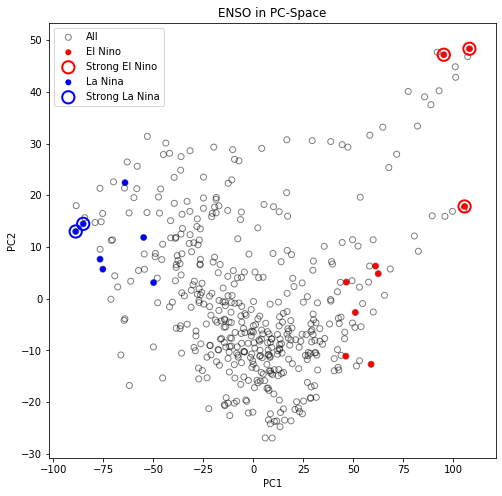

In [42]:
#visualize in PC1-PC2 space

plt.figure(figsize=(8,8))

plt.scatter(PCs[:,0],PCs[:,1],facecolors=[],edgecolors='k',alpha=0.5)
plt.scatter(PCs[allElNino,0],PCs[allElNino,1],facecolors='r',edgecolors=[])
plt.scatter(PCs[strongElNino,0],PCs[strongElNino,1],facecolors=[],edgecolors='r',s=150,linewidth=2)
plt.scatter(PCs[allLaNina,0],PCs[allLaNina,1],facecolors='b',edgecolors=[])
plt.scatter(PCs[strongLaNina,0],PCs[strongLaNina,1],facecolors=[],edgecolors='b',s=150,linewidth=2)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ENSO in PC-Space')
plt.legend(['All','El Nino','Strong El Nino','La Nina','Strong La Nina'])

plt.show()

Now, we'll do rotated PCA and compare.

In [54]:
#first, define the varimax function -- thank you to stackoverflow for providing this function
# https://stackoverflow.com/questions/17628589/perform-varimax-rotation-in-python-using-numpy
# This gives slightly different results as compared to the MATLAB version, but is generally similar

from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R), R

In [64]:
#use varimax function to return the rotated PCs and rotation matrix, then rotate eigenvectors 
RPCs,R = varimax(PCs,q=100)
Reigvecs = eigvecs.T@R
Reigvecs = Reigvecs.T

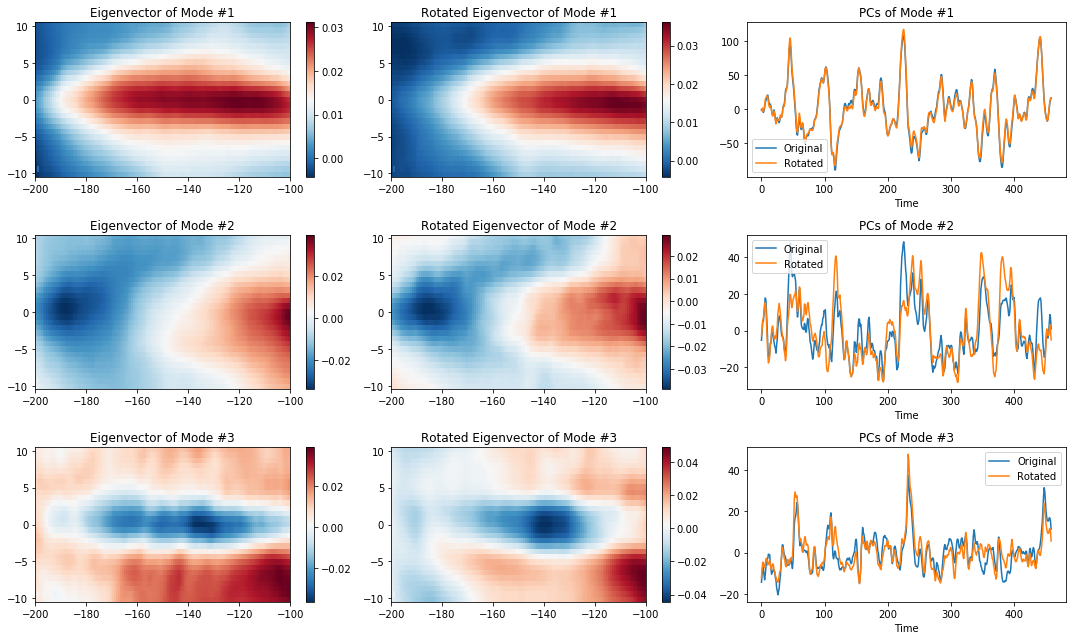

In [70]:
#visualize how the eigenvectors and PCs are different between rotated and regular

n = 3

extent = [-200,-100,-10.5,10.5]
plt.figure(figsize=(15,3*n))
for kk in range(n):
    
    plt.subplot(n,3,kk*3+1)
    plt.imshow(np.reshape(eigvecs[kk,:],(29,135)),extent=extent,cmap = 'RdBu_r',aspect='auto')
    plt.xlim(extent[:2])
    plt.ylim(extent[2:])
    plt.title('Eigenvector of Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,3,kk*3+2)
    plt.imshow(np.reshape(Reigvecs[kk,:],(29,135)),extent=extent,cmap = 'RdBu_r',aspect='auto')
    plt.xlim(extent[:2])
    plt.ylim(extent[2:])
    plt.title('Rotated Eigenvector of Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,3,kk*3+3)
    plt.plot(PCs[:,kk])
    plt.plot(RPCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Time')
    plt.legend(['Original','Rotated'])
    
    plt.tight_layout()